# PEC 1: APRENDIJAZE POR REFUERZO

Tomar el notebook 02_bandidos_contextuales_por_estados_adversarios_exp3.ipynb del Bloque 1 de los bandidos subido en el material del bloque 3 y realizar las siguientes tareas:

* Documenta cada función y clase, explicando qué hacen.
* Prueba distintos parámetros para el mismo problema de bandidos en el agente. ¿Con cuál obtienes mayor beneficio?


Para la resolución de este ejercicio se usa como base el notebook comentando toda clase y función, y también el punto 2.0.2 Lanzamos un experimento para comparar con los resultados aleatorios. El resto del código se entiende que está ya comentado mediante el uso de celdas markdown para explicar lo que se está haciendo.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Aprendizaje-por-refuerzo-simple" data-toc-modified-id="Aprendizaje-por-refuerzo-simple-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Aprendizaje por refuerzo simple</a></span><ul class="toc-item"><li><span><a href="#Bandido-multiarmado" data-toc-modified-id="Bandido-multiarmado-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Bandido multiarmado</a></span></li><li><span><a href="#Bandidos-contextuales" data-toc-modified-id="Bandidos-contextuales-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Bandidos contextuales</a></span><ul class="toc-item"><li><span><a href="#Escenarios" data-toc-modified-id="Escenarios-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Escenarios</a></span></li><li><span><a href="#Beneficio-de-realizar-la-elección-de-acciones-aleatoriamente" data-toc-modified-id="Beneficio-de-realizar-la-elección-de-acciones-aleatoriamente-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Beneficio de realizar la elección de acciones aleatoriamente</a></span></li></ul></li></ul></li><li><span><a href="#Programamos-un-EXP3-para-comparar-con-el-problema-anterior" data-toc-modified-id="Programamos-un-EXP3-para-comparar-con-el-problema-anterior-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Programamos un EXP3 para comparar con el problema anterior</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Ejemplo-de-toma-de-acción-y-actualización-de-pesos" data-toc-modified-id="Ejemplo-de-toma-de-acción-y-actualización-de-pesos-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Ejemplo de toma de acción y actualización de pesos</a></span></li><li><span><a href="#Lanzamos-un-experimento-para-comparar-con-los-resultados-aleatorios" data-toc-modified-id="Lanzamos-un-experimento-para-comparar-con-los-resultados-aleatorios-2.0.2"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>Lanzamos un experimento para comparar con los resultados aleatorios</a></span></li></ul></li></ul></li></ul></div>

# Aprendizaje por refuerzo simple

## Bandido multiarmado

Es el ejemplo más básico de aprendizaje por refuerzo. Consiste en una serie de acciones y recompensas posibles en cada momento que verifican las siguientes condiciones:

- Acciones distintas dan recompensas distintas.
- Las recompensas son inmediatas o en el mismo período de elección antes de decidir la siguiente acción.
- La recompensa por una acción no depende del estado del entorno.

La idea del bandido multiarmado es que va probando sus distintas acciones posibles, y observa qué recocmpensas obtiene. Conforme se ejecutan acciones se tiene información de la recompensa de cada una, y el bandido va ejecutando con más frecuencia aquellas acciones cuya recompensa es más alta, pero sin dejar de pulsar aquellas cuya recompensa es menor de vez en cuando.

Esto resuelve el dilema de **exploración y explotación**, con más información [aquí](https://steemit.com/technology/@mor/machine-learning-series-part-5-exploration-vs-exploitation-dilemma-in-reinforcement-learning) y [aquí](http://www.cogsci.ucsd.edu/~ajyu/Teaching/Cogs202_sp16/Slides/lect4.pdf). Básicamente consiste en explotar las opciones conocidas como mejores o explorar nuevas opciones que puedan mejorar las actuales, hay un coste de oportunidad implícito en ambas elecciones.

Se recomienda la lectura del siguiente [enlace](https://medium.com/@awjuliani/super-simple-reinforcement-learning-tutorial-part-1-fd544fab149) antes de proseguir.

## Bandidos contextuales

Si queremos aplicar bandidos que actúen en distitons estados del entorno, podemos crear una serie de contextos y a cada contexto asignarle un bandido con sus correspondientes acciones que actúe sólo en ese escenario y aprenda independientemente del resto. Esto se conoce como **bandidos contextuales**.

### Escenarios
Here we define our contextual bandits. In this example, we are using three four-armed bandit. What this means is that each bandit has four arms that can be pulled. Each bandit has different success probabilities for each arm, and as such requires different actions to obtain the best result. The pullBandit function generates a random number from a normal distribution with a mean of 0. The lower the bandit number, the more likely a positive reward will be returned. We want our agent to learn to always choose the bandit-arm that will most often give a positive reward, depending on the Bandit presented.

En la siguiente clase creamos contextos y bandidos con opciones:

- Cada contexto tiene generada aleatoriamente tantos valores de una distribución normal como acciones posibles tiene el bandido de ese contexto. 
- El dinero que gana cada bandido  ejcutando una acción es el el resultado de una extracción de una normal menos el valor guardado para la acción del contexto  correspondiente a ese bandido.

In [4]:
import numpy as np
from scipy.special import logsumexp
import pandas as pd
from tqdm import tqdm
import seaborn as sns
%matplotlib inline


class ContextualBandits():
    """
    Esta clase pretende emular el entorno.
    """

    def __init__(self, num_bandits, num_actions):
        """
        Método de inicialización.
        
        - num_bandits: número de estados.
        - num_actions: número de acciones.
        """
        self.state = 0
        self.bandits = np.random.randn(num_bandits, num_actions)
        self.num_bandits = num_bandits
        self.num_actions = num_actions

    def get_bandit(self):
        """
        Método que devuelve un estado de forma aleatoria.
        """
        # Returns a random state for each episode.
        self.state = np.random.randint(0, self.num_bandits)
        return self.state

    def pull_arm(self, action):
        """
        Método que devuelve una recompensa en función de la acción.
        
        - action: acción tomada de la que se quiere obtener la recompensa.
        
        """

        bandit = self.bandits[self.state, action]
        result = np.random.randn(1)

        return np.sum(result - bandit)

    def reset_bandit(self):
        """
        Método que reinicializa la matriz que define la recompensa. 
        Sirve para simular un cambio en la distribuciñón de las recompensas.
        """
        num_res = np.random.randint(self.num_bandits)
        bandits_reset = np.random.choice(np.arange(0, self.num_bandits), num_res, replace=False)
        self.bandits[bandits_reset] = np.random.randn(num_res, self.num_actions)

Creamos 10 contextos ó bandidos que tienen 3 acciones cada uno

In [5]:
N_BANDITS = 10
N_ACTIONS = 3

bands = ContextualBandits(10,3)
bands.bandits.shape

(10, 3)

La siguiente matriz indica para cada una de las 10 filas (bandidos) cada uno de los estados de las 3 acciones. Conforme más negativo es el número asignado a una acción esta es más rentable. Esto es algo que desconoceremos en la realidad y querremos averiguar.

In [6]:
bands.bandits

array([[ 0.08352039, -0.30207032, -2.46691321],
       [ 0.90718611,  1.17599733,  0.02925788],
       [-1.20103382, -1.17995521,  2.7776259 ],
       [-1.08348984, -0.2947699 ,  1.30659976],
       [-0.54854714,  0.85858571, -0.46756058],
       [ 1.00502101,  0.61747007, -0.98947437],
       [-0.31365481, -0.35648044,  0.07690909],
       [-1.52994222, -1.69874909,  0.41916935],
       [-0.17748496, -0.60360047,  2.31011721],
       [-0.38977905, -1.27686009,  1.86225147]])

Método que extrae el contexto que toca en cada momento:

In [7]:
bands.get_bandit()

0

In [8]:
bands.state

0

Para simular una situación real ponemos un método `.reset_bandits`

In [9]:
bands.reset_bandit()

In [10]:
bands.bandits

array([[ 0.08352039, -0.30207032, -2.46691321],
       [ 0.67894648, -0.61054431,  1.09501751],
       [-1.20103382, -1.17995521,  2.7776259 ],
       [-1.08348984, -0.2947699 ,  1.30659976],
       [-0.54854714,  0.85858571, -0.46756058],
       [ 1.00502101,  0.61747007, -0.98947437],
       [ 0.27071087,  0.30553965, -1.41531809],
       [-1.52994222, -1.69874909,  0.41916935],
       [-0.17748496, -0.60360047,  2.31011721],
       [ 1.05591172,  0.03123861,  0.66899917]])

Elegir opción para el bandido actual y te dice el beneficio obtenido

In [11]:
bands.pull_arm(2)

3.3321510460603316

### Beneficio de realizar la elección de acciones aleatoriamente

Creamos funciones que permiten ejecutar experimentos

In [12]:
def experimento_bandidos(bandido, episodios):
    """
    Experimento que pretende calcular el beneficio que se obtendría si se hace una selección aleatoria.
    
    - bandido: el entorno.
    - episidios: iteraciones.
    """
    beneficio = 0

    for k in range(episodios):
        bandido.get_bandit()
        beneficio += bandido.pull_arm(np.random.choice(bandido.num_actions))
    return beneficio


def simulaciones_bandidos(n, bandido, episodios):
    """
    Simulación del experimento anterior para un número n de veces. 
    Almacena los resultados del experimento.
    
    - n: número de veces que se ejecuta el experimento.
    - bandido: el entorno; parámetro de la función anterior.
    - episidios: iteraciones; parámetro de la función anterior.
    """
    lista = []
    for i in tqdm(range(n), desc="RUNNING EXPERIMENTS"):
        lista.append(experimento_bandidos(bandido, episodios))
    return lista

Creamos una clase de bandidos con 100 contextos y 3 acciones posibles en cada contexto. Establecemos que haremos 2000 experimentos.

In [13]:
N_CONTEXTS = 100
N_ACTIONS = 3

N_EXPERIMENTS = 30
N_EPOCHS = 20000

np.random.seed(0)
cont_bandit = ContextualBandits(N_CONTEXTS, N_ACTIONS)

sims = pd.Series(simulaciones_bandidos(N_EXPERIMENTS, cont_bandit, N_EPOCHS))
sims

RUNNING EXPERIMENTS: 100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


0    -444.747985
1    -597.077611
2    -447.441508
3    -414.715762
4    -532.173664
5    -501.853328
6    -500.360382
7     -94.655578
8    -511.894618
9    -993.029395
10   -402.917700
11   -307.735917
12   -663.561023
13   -802.704075
14   -510.551881
15   -391.481272
16   -774.442207
17   -411.087147
18   -662.897915
19   -365.982646
20   -438.239997
21   -685.519581
22   -551.559645
23   -389.776119
24   -653.863987
25   -882.575717
26   -530.433202
27   -749.066331
28    -94.135379
29   -790.174332
dtype: float64

En cada uno de los experimentos con `N_EPOCHS` obtenemos una media de beneficio de 

In [14]:
sims.mean()

-536.5551967928858

Beneficio medio por acción:


In [15]:
sims.mean() / N_EPOCHS

-0.02682775983964429

In [16]:
sims.describe()

count     30.000000
mean    -536.555197
std      205.973901
min     -993.029395
25%     -663.395246
50%     -511.223250
75%     -411.994301
max      -94.135379
dtype: float64

/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

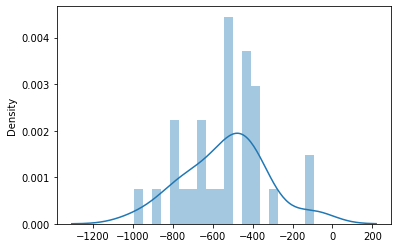

In [17]:
sns.distplot(sims, bins=20)

# Programamos un EXP3 para comparar con el problema anterior

Un tipo de agente que se adapta a cambios dinámicos en los rendimientos de las acciones de los contextos es el **algoritmo EXP3**. El agente comienza con iguales pesos para cada una de las acciones y va modificando estos pesos exponencialmente en función del beneficio de cada acción.

Más información sobre bandidos adversarios [aquí](http://banditalgs.com/2016/10/01/adversarial-bandits/).

El algoritmo que implementamos es el siguiente:

<img src='EXP3.png'>

Sólo que la implementación que realizamos usa pesos en la versión logarítmica para evitar el **overflow**. Además ponemos una probabilidad mínima para cada acción de modo que nunca dejamos de probar con cierta probabilidad cada posibilidad:

In [18]:
class agente_EXP3():
    
    """
    Clase que pretende emular un agente EXP3, que es un algoritmo de bandidos adversarios contextual.
    Es decir, para cada estado hay unos parámetros
    """

    def __init__(self, s_size, a_size, p_min, lr_speed=1):
        """ lr_speed vale 1 por defecto, modificarla cambia la tasa de aprendizaje"""
        
        """
        Método de inicialización.
        
        - s_size: número de estados
        - a_size: número de acciones
        - p_min: probabilidad mínima
        - lr_speed: velocidad de la tasa de aprendizaje. Valor 1 por defecto. A mayor valor, se acelera el aprendizaje.
        """
        self.s_size = s_size
        self.a_size = a_size
        self.a_vector = np.arange(a_size)
        self.p_min = p_min
        self.gamma = p_min * a_size
        self.lr_speed = p_min * lr_speed

        # Inicializar matriz de pesos y probabilidades
        self.W = np.zeros((s_size, a_size))
#         self.P = (1 - self.gamma) * self.W / np.sum(self.W, axis=1).reshape(s_size,1) + self.p_min
        # P: probabilidad de tomar cada acción en cada estado
        self.P = (1 - self.gamma) * np.exp(self.W - logsumexp(self.W, axis=1).reshape(s_size, 1)) + self.p_min

    def get_action(self, bandit):
        """ El coeficiente velocidad de aprendizaje suele ser igual que p_min"""
        
        """
        Método que devuelve una acción que se toma aleatoriamente del vector de acciones con la probabilidad que
        se obtiene de la tabla de probabilidades a partir del estado que se introduce como parámetro.
        
        - bandit: estado
        """
#         w = self.W[bandit]
#         P = (1 - self.gamma) * w / np.sum(w) + self.p_min
        action = np.random.choice(self.a_vector, p=self.P[bandit])
#         print('El estado %d tiene vector de probabilidades %r' %(bandit, self.P[bandit]))
        return action

    def update_with_reward(self, bandit, action, reward):
        """
        Método que actualiza el estado interno a partir de un estado, con una acción, y la recompensa obtenida.
        
        - bandit: estado en el que se ha llevado la acción
        - action: acción llevada a cabo
        - reward: recompensa obtenida a partir de haber realizado una acción en un estado determinado.
        """
        self.W[bandit, action] += self.lr_speed * reward / self.P[bandit, action]
        self.P[bandit] = (1 - self.gamma) * self.W[bandit] / np.sum(self.W[bandit]) + self.p_min
        self.P[bandit] = (1 - self.gamma) * np.exp(self.W[bandit] - logsumexp(self.W[bandit])) + self.p_min

Pesos iniciales:

In [19]:
# Se genera un agente
agente = agente_EXP3(N_BANDITS, N_ACTIONS, 0.05, 5)
agente.W

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

El estado inicial de las probabilidades de cada acción para cada contexto o bandido. Al principio es igual para todos

In [20]:
# self.W / np.sum(self.W, axis=1).reshape(s_size,1)
np.exp(agente.W - logsumexp(agente.W, axis=1).reshape(N_BANDITS, 1))

array([[0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333]])

### Ejemplo de toma de acción y actualización de pesos

In [21]:
# Generar un agente
ag = agente_EXP3(500,3,0.1)

El agente creado da una acción para cada contexto que le proporcionemos basada en la probabilidad de bondad de dicha acción almacenada en sus pesos_

In [22]:
ag.get_action(3)

0

Tras realizar una acción tenemos una recompensa y podemos actualizar los pesos:

In [23]:
ag.update_with_reward(2, 1, 5)

In [24]:
ag.W

array([[0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 1.5, 0. ],
       ...,
       [0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ]])

### Lanzamos un experimento para comparar con los resultados aleatorios

**Pregunta: Prueba distintos parámetros para el mismo problema de bandidos en el agente. ¿Con cuál obtienes mayor beneficio?**

Para resolver esta pregunta se van a analizar diferentes combinaciones para los valores de probabilidad mínima y de velocidad de la taa de aprendizaje sobre el mismo entorno, por lo que se mantienen los parámetros N_CONTEXTS y N_ACTIONS sin modificar.


In [61]:
# Listas con los valores de los parámetros a probar
lr_speed = [1,2,3,4,5]
p_min = [0.05,0.1,0.15,0.2]

# Dataframe base para almacenar los resultados
df = pd.DataFrame(columns = ["lr_speed", "p_min", "% aciertos", "beneficio medio", "beneficio acumulado"])

# Lista para almacenar los beneficios de cada experimento con las diferentes combinaciones de parámetros
beneficio_total = []

for i in lr_speed:
    for j in p_min:
        
        # Generar bandido contextual, es decir, el entorno
        cont_bandit = ContextualBandits(N_CONTEXTS, N_ACTIONS)

        # Generar el agente
        agente = agente_EXP3(N_CONTEXTS, N_ACTIONS, j, i)

        # Generar una matriz de recompensas totales
        total_reward = np.zeros([cont_bandit.num_bandits, cont_bandit.num_actions])

        beneficio = []

        # Comienzo del experimento
        for k in tqdm(range(N_EPOCHS)):

            # Obtener estado
            s = cont_bandit.get_bandit()

            # Obtener una acción para el estado
            action = agente.get_action(s)

            # Obtener la recompensa a partir de la acción
            reward = cont_bandit.pull_arm(action)

            # Añadir la recompensa a la lista para su almacenamiento
            beneficio.append(reward)

            # Modificar tabla de probabilidades y pesos a partir de la recompensa obtenida para la acción en el estado
            agente.update_with_reward(s,action,reward)

            # Añadir la recompensa a la tabla de recompensas totales para el estado y acción correspondiente.
            total_reward[s,action] += reward

            # Cada 500 iteraciones se resetea el contexto y la distribución de recompensas.
            if k % 500 == 0:
                cont_bandit.reset_bandit()
            
        aciertos = 0
        for s in range(cont_bandit.num_bandits):
            # Cálculo de métricas para evaluar los beneficios.
            if np.argmax(agente.W[s]) == np.argmin(cont_bandit.bandits[s]):
                aciertos += 1
                
        # Añadir los resultados al dataframe de resultados
        new_row = {"lr_speed": str(i), "p_min": str(j), "% aciertos": aciertos/cont_bandit.num_bandits, 
                   "beneficio medio": np.mean(beneficio), "beneficio acumulado": np.sum(beneficio)}
        df = df.append(new_row, ignore_index = True)
        
        # Añadir los beneficios a la lista de beneficios totales
        beneficio_total.append(beneficio) 
        

100%|██████████| 20000/20000 [00:03<00:00, 6047.48it/s]


In [62]:
# Resultados
df

,lr_speed,p_min,% aciertos,beneficio medio,beneficio acumulado
0,1,0.05,0.48,0.088298,1765.959579
1,1,0.1,0.34,0.115878,2317.558592
2,1,0.15,0.38,0.129139,2582.776335
3,1,0.2,0.43,0.067367,1347.345665
4,2,0.05,0.45,0.119982,2399.647110
5,2,0.1,0.42,0.129408,2588.159394
6,2,0.15,0.39,0.122525,2450.495435
7,2,0.2,0.41,0.062761,1255.211782
8,3,0.05,0.43,0.143904,2878.079874
9,3,0.1,0.33,0.137098,2741.952512


In [56]:
# Obtener el índice del experimento cuyo beneficio medio ha sido mayor
max_ben_index = df["beneficio medio"].idxmax()

# Obtener la tasa de aprendizaje y la probabilidad mínica del experimento cuyo beneficio medio ha sido mayor
lr_speed = int(df.loc[max_ben_index, "lr_speed"])
p_min = float(df.loc[max_ben_index, "p_min"])

print("El mayor beneficio medio obtenido fue de {} con un benedificio acumulado de {}, y se obtuvo con una \
probabilidad mínima de {} y una velocidad de tasa de aprendizaje igual a {}.\
".format(df.loc[max_ben_index, "beneficio medio"], df.loc[max_ben_index, "beneficio acumulado"], p_min, lr_speed))

El mayor beneficio medio obtenido fue de 0.1771112340573745 con un benedificio acumulado de 3542.22468114749, y se obtuvo con una probabilidad mínima de 0.05 y una velocidad de tasa de aprendizaje igual a 4.


Mostrar el cambio en la ditribución de los beneficios.

/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


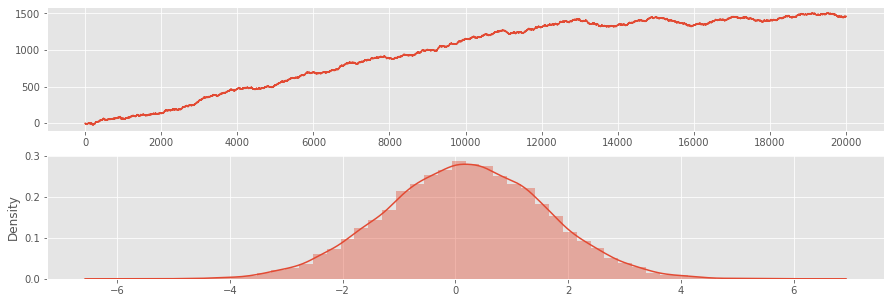

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

f,ax = plt.subplots(2,1,figsize=(15,5))
ejes = ax.ravel()
ejes[0].plot(np.cumsum(beneficio));
ejes[0].set_xticks(np.linspace(0,20000,11))

sns.distplot(beneficio_total[max_ben_index], ax=ejes[1]);
# plt.close(g)